# Survival Analysis with Python

## ⚙️ Imports

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import torch
import xgboost as xgb
from fpboost.models import FPBoost
from pycox.models import CoxPH, DeepHitSingle
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sksurv.datasets import load_gbsg2
from sksurv.metrics import concordance_index_censored
from sksurv.ensemble import RandomSurvivalForest
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.nonparametric import kaplan_meier_estimator
from sklearn.model_selection import train_test_split
import torchtuples as tt

%matplotlib inline

np.random.seed(42)
torch.manual_seed(42);

## 💾 Load Data

In this notebook, we will use the [German Breast Cancer Study Group 2](https://scikit-survival.readthedocs.io/en/stable/api/generated/sksurv.datasets.load_gbsg2.html) dataset.

In [2]:
X, y = load_gbsg2()
print(f"X: shape={X.shape}, type={type(X)}")
print(f"y: shape={y.shape}, type={type(y)}")

X: shape=(686, 8), type=<class 'pandas.core.frame.DataFrame'>
y: shape=(686,), type=<class 'numpy.ndarray'>


### Feature Preprocessing

In [3]:
X.head()

,age,estrec,horTh,menostat,pnodes,progrec,tgrade,tsize
0,70.0,66.0,no,Post,3.0,48.0,II,21.0
1,56.0,77.0,yes,Post,7.0,61.0,II,12.0
2,58.0,271.0,yes,Post,9.0,52.0,II,35.0
3,59.0,29.0,yes,Post,4.0,60.0,II,17.0
4,73.0,65.0,no,Post,1.0,26.0,II,35.0


In [4]:
# Convert the tgrade column to numeric
if "I" in X["tgrade"].unique():
    tgrade_dict = {"I": 1, "II": 2, "III": 3}
    X["tgrade"] = X["tgrade"].map(tgrade_dict)

print(f"tgrade unique values: {X['tgrade'].unique()}")

tgrade unique values: [2, 3, 1]
Categories (3, int64): [1, 2, 3]


In [5]:
# Split the data into train, validation and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print(f"X_train: shape={X_train.shape}, type={type(X_train)}")
print(f"X_val: shape={X_val.shape}, type={type(X_val)}")
print(f"X_test: shape={X_test.shape}, type={type(X_test)}")

X_train: shape=(438, 8), type=<class 'pandas.core.frame.DataFrame'>
X_val: shape=(110, 8), type=<class 'pandas.core.frame.DataFrame'>
X_test: shape=(138, 8), type=<class 'pandas.core.frame.DataFrame'>


In [6]:
preprocessor = None

In [7]:
# Preprocess the data by scaling the numerical features 
# and one-hot encoding the categorical features
cat_cols = [2, 3]
num_cols = [i for i in range(X.shape[1]) if i not in cat_cols]

if preprocessor is None:
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), num_cols),
            ("cat", OneHotEncoder(drop="if_binary"), cat_cols),
        ]
    )
    X_train = preprocessor.fit_transform(X_train)
    X_val = preprocessor.transform(X_val)
    X_test = preprocessor.transform(X_test)

for i, col in enumerate(num_cols):
    print(f"Feature {col} mean: {np.mean(X_train[:, i]):.4f}, std: {np.std(X_train[:, i]):.4f}")

Feature 0 mean: 0.0000, std: 1.0000
Feature 1 mean: 0.0000, std: 1.0000
Feature 4 mean: -0.0000, std: 1.0000
Feature 5 mean: 0.0000, std: 1.0000
Feature 6 mean: 0.0000, std: 1.0000
Feature 7 mean: -0.0000, std: 1.0000


### Label Preprocessing

In [8]:
y[:5]

array([( True, 1814.), ( True, 2018.), ( True,  712.), ( True, 1807.),
       ( True,  772.)], dtype=[('cens', '?'), ('time', '<f8')])

In [9]:
y["cens"][:5], y["time"][:5]

(array([ True,  True,  True,  True,  True]),
 array([1814., 2018.,  712., 1807.,  772.]))

In [10]:
# Example on how to build a custom y array with the sksurv typing
events = [True, False, True, True, False]
times = [1, 2, 3, 4, 5]

dtype = [("cens", bool), ("time", float)]

custom_y = np.array(list(zip(events, times)), dtype=dtype)
custom_y

array([( True, 1.), (False, 2.), ( True, 3.), ( True, 4.), (False, 5.)],
      dtype=[('cens', '?'), ('time', '<f8')])

## 🧮 Kaplan-Meier Estimator

Time: 8.00, Survival: 1.0000
Time: 357.00, Survival: 0.9146
Time: 553.00, Survival: 0.8029
Time: 758.00, Survival: 0.7241
Time: 1059.00, Survival: 0.6368
Time: 1343.00, Survival: 0.5609
Time: 1721.00, Survival: 0.5057
Time: 2049.00, Survival: 0.4141


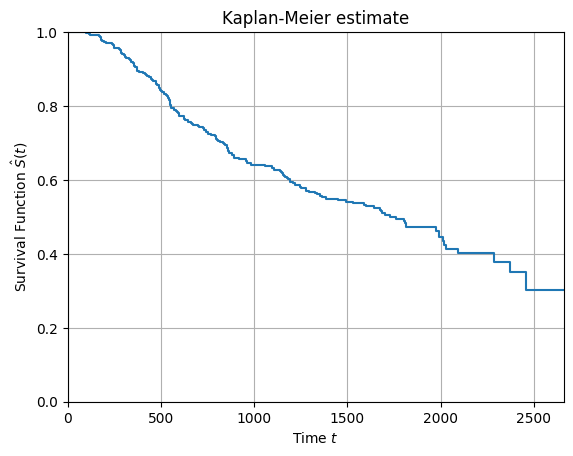

In [11]:
events, times = y_train["cens"], y_train["time"]
km_time, km_surv = kaplan_meier_estimator(events, times)

for i in range(0, len(km_time), 50):
    print(f"Time: {km_time[i]:.2f}, Survival: {km_surv[i]:.4f}")

plt.step(km_time, km_surv, where="post")
plt.ylabel(r"Survival Function $\hat{S}(t)$")
plt.xlabel(r"Time $t$")
plt.title("Kaplan-Meier estimate")
plt.ylim(0, 1)
plt.xlim(0, np.max(times))
plt.grid(True)
plt.show();

## 🧠 Survival Models

In [12]:
def concordance_index(y_true, preds):
    return float(concordance_index_censored(y_true["cens"], y_true["time"], preds)[0])

### Cox

In [13]:
estimator = CoxPHSurvivalAnalysis()
estimator.fit(X_train, y_train)

preds = estimator.predict(X_test)
score = concordance_index(y_test, preds)

print(f"CoxPH model concordance index: {score:.4f}")

CoxPH model concordance index: 0.6369


### Random Survival Forest

In [14]:
estimator = RandomSurvivalForest(random_state=42)
estimator.fit(X_train, y_train)

preds = estimator.predict(X_test)
score = concordance_index(y_test, preds)

print(f"RandomSurvivalForest model concordance index: {score:.4f}")

RandomSurvivalForest model concordance index: 0.6507


### Fully Parametric Gradient Boosting

In [15]:
estimator = FPBoost(random_state=42)
estimator.fit(X_train, y_train)

preds = estimator.predict(X_test)
score = concordance_index(y_test, preds)

print(f"FPBoost model concordance index: {score:.4f}")

FPBoost model concordance index: 0.6819


### DeepSurv

In [16]:
_X_train = X_train.astype(np.float32)
_y_train = (y_train["time"].copy(), y_train["cens"].copy())
_y_train = (_y_train[0].astype(np.float32), _y_train[1].astype(np.float32))
_y_val = (y_val["time"].copy(), y_val["cens"].copy())
_y_val = (_y_val[0].astype(np.float32), _y_val[1].astype(np.float32))
val_data = (X_val.astype(np.float32), _y_val)

in_features = _X_train.shape[1]

net = tt.practical.MLPVanilla(
    in_features,
    [i * in_features for i in [3, 5, 3]],  # hidden layers as in Katzman et al., 2018
    1,  # output layer
    batch_norm=True,
    dropout=0.6,
)
callbacks = [
    tt.callbacks.EarlyStopping(patience=10),
    tt.callbacks.StopIfExplodeOrNan(),
]

estimator = CoxPH(net, tt.optim.Adam)  # DeepSurv model
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    estimator.fit(
        _X_train,
        _y_train,
        batch_size=32,
        epochs=50,
        val_data=val_data,
        callbacks=callbacks,
        verbose=False,
    )
estimator.compute_baseline_hazards()

preds = estimator.predict_surv_df(X_test.astype(np.float32))
times = np.linspace(0, y_test["time"].max(), 100)
unique_times = preds.index.to_numpy()
preds = np.array([preds.iloc[:, i].values for i in range(preds.shape[1])])
surv = np.zeros((X_test.shape[0], len(times)))
for i, t in enumerate(times):
    idx = np.abs(unique_times - t).argmin()
    surv[:, i] = preds[:, idx]
risk = -np.sum(surv, axis=1)

score = concordance_index(y_test, risk)
print(f"DeepSurv model concordance index: {score:.4f}")

DeepSurv model concordance index: 0.6641


### DeepHit

In [17]:
num_durations = 10

labtrans = DeepHitSingle.label_transform(num_durations)
_y_train = labtrans.fit_transform(
    y_train["time"].astype(np.float32), y_train["cens"].astype(np.float32)
)
_y_val = labtrans.transform(y_val["time"].astype(np.float32), y_val["cens"].astype(np.float32))
val_data = (X_val.astype(np.float32), _y_val)
net = tt.practical.MLPVanilla(
    X_train.shape[1],
    [i * X_train.shape[1] for i in [3, 5, 3]],
    num_durations,  # outputs
    batch_norm=True,
    dropout=0.6,
)
callbacks = [
    tt.callbacks.EarlyStopping(patience=10),
    tt.callbacks.StopIfExplodeOrNan(),
]

estimator = DeepHitSingle(net, tt.optim.Adam, alpha=0.5, duration_index=labtrans.cuts)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    estimator.fit(
        X_train.astype(np.float32),
        _y_train,
        batch_size=32,
        epochs=50,
        val_data=val_data,
        callbacks=callbacks,
        verbose=False,
    )

preds = estimator.predict_surv_df(X_test.astype(np.float32))
times = np.linspace(0, y_test["time"].max(), 100)
unique_times = preds.index.to_numpy()
preds = np.array([preds.iloc[:, i].values for i in range(preds.shape[1])])
surv = np.zeros((X_test.shape[0], len(times)))
for i, t in enumerate(times):
    idx = np.abs(unique_times - t).argmin()
    surv[:, i] = preds[:, idx]
risk = -np.sum(surv, axis=1)

score = concordance_index(y_test, risk)
print(f"DeepHit model concordance index: {score:.4f}")

DeepHit model concordance index: 0.4984


### XGBoost

In [18]:
dtrain = xgb.DMatrix(X_train, label=y_train["time"])
dval = xgb.DMatrix(X_val, label=y_val["time"])
dtest = xgb.DMatrix(X_test, label=y_test["time"])

params = {
    "objective": "survival:cox",
    "eval_metric": "cox-nloglik",
    "seed": 42,
    "eta": 0.01,
    "max_depth": 6,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "lambda": 1.0,
    "alpha": 0.1,
}

estimator = xgb.train(
    params=params,
    dtrain=dtrain,
    evals=[(dtrain, "train"), (dval, "val")],
    early_stopping_rounds=10,
    num_boost_round=500,
    verbose_eval=False,
)

preds = estimator.predict(dtest)
score = concordance_index(y_test, preds)
print(f"XGBoost model concordance index: {score:.4f}")

XGBoost model concordance index: 0.6177
